Michael Procko
This repo serves as a programming example for the Summer Workshop on Computer Vision Methods for Ecology 2023

Within this repo, you will find:
- Procko_M_prog_ex.ipynb: a code which...
    + imports raw camera trap detection data and concatenates into one dataframe
    + filters camera trap detection data into independent detections using a 30-minute threshold for wildlife detections and 1-minute threshold of human-related detections
    + formats camera trap detection data into station * week detection data, with the days each camera was active per week being calculated to allow for sampling effort calculations later
    + calculates weekly detections and detection rates (using the sampling effort of each camera) for elk, deer, black bears, cougars, coyotes, bobcats, hikers, mountain bikers, horseback riders, motorized vehicles, and domestic dogs 
    + constructs a random forest model, currently set up to classify stations-weeks where elk were detected as a binary response variable. Elk detection/non-detection was predicted as a function of all human-related detection rates
    + extracts variable importance information from the random forest algorithm to identify the strongest predictors of elk detection/non-detection
    + plots variable importance
    + assesses random forest model accuracy with confusion matrix and calculation of precision/recall/F1 scores
    + plot the relationship between hiker detection rate and elk detection probability using a GAM spline
- raw_data.zip
    + .zip containing all raw detection data
- MASTER_DEPLOYMENTS_2022-10-11.csv
    + .csv containing data on camera deployments (camera start date, end date, etc.)

Note that the following four-letter appreviations are used for all wildlife species, each corresponding to the first two letter of their genus & species: {'ceca' : elk, 'odhe' : black-tailed deer, 'uram' : blackbear, 'puco' : cougar, 'cala' : coyote, 'lyru' : bobcat}


In [2]:
### PACKAGES AND DATA IMPORT ###

# import packages
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
from sklearn.utils.extmath import cartesian
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from scipy.interpolate import UnivariateSpline

# set path to location where detection data .csvs are stored
path = r'/Users/michaelprocko/Documents/Work:Money/UW/Elk Project/3. Data/3.3 Raw Data and Scripts/ElkProject/data/raw' 
all_files = glob.glob(os.path.join(path, "*.csv"))  # use os.path.join as this makes concatenation OS independent

# read in detection data .csvs and concatenate together into one "df"
df_from_each_file = (pd.read_csv(f) for f in all_files) # list all files
df = pd.concat(df_from_each_file, ignore_index=True) # concat files
df.head() # preview

# read in camera activity data, set aside for later
cam_act = pd.read_csv('/Users/michaelprocko/Documents/Work:Money/UW/Elk Project/3. Data/3.3 Raw Data and Scripts/ElkProject/data/MASTER_DEPLOYMENTS_2022-10-11.csv')

In [3]:
### PRELIM DATA MANAGEMENT ###

# cleaning up raw data
df = df.drop(labels="RelativePath", axis=1) # drop unneccesary columns
df = df.drop(labels="ImageQuality", axis=1) 
df.DateTime = pd.to_datetime(df['DateTime'], format = '%Y-%m-%d %H:%M:%S') # typecast DateTime 
df = df[df['DeleteFlag']==False] # remove empty images
df = df.sort_values(by = ['Folder', 'DateTime']) # reorder by Folder (Camera station), then DateTime
df["latin_name"] = np.nan # create new column for species name

# split into human behaviours and wildlife dfs
hiker_df = df[(df['Hikers']>0)] 
biker_df = df[(df['MtnBikers']>0)]
horse_df = df[(df['Horseback']>0)]
motor_df = df[(df['Vehicles']>0)]
doggo_df = df[(df['Dogs']>0)]

ceca_df = df[(df['Elk']>0)]
odhe_df = df[(df['MuleDeer']>0)]
puco_df = df[(df['Cougars']>0)]
uram_df = df[(df['BlackBear']>0)]
cala_df = df[(df['Coyote']>0)]
lyru_df = df[(df['Bobcat']>0)]

# label latin_name for each of these
hiker_df['latin_name'] = "Hiker"
biker_df['latin_name'] = "MtnBiker"
horse_df['latin_name'] = "Horseback"
motor_df['latin_name'] = "Vehicle"
doggo_df['latin_name'] = "Dog"

ceca_df['latin_name'] = "Cervus canadensis"
odhe_df['latin_name'] = "Odocoileus hemionus"
puco_df['latin_name'] = "Puma concolor"
uram_df['latin_name'] = "Ursus americanus"
cala_df['latin_name'] = "Canis latrans"
lyru_df['latin_name'] = "Lynx rufus"

/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/3810381581.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hiker_df['latin_name'] = "Hiker"
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/3810381581.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  biker_df['latin_name'] = "MtnBiker"
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/3810381581.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [4]:
### INDEPENDENCE THRESHOLDING ###

# define independence thresholds... for human-related variables, we'll use one minute, and for wildlife, 30 minutes
hum_thresh = pd.to_timedelta(1, unit="m")
wild_thresh = pd.to_timedelta(30, unit="m")

# calculate time since last image for each camera station, per human behaviour
human_dfs = [hiker_df, biker_df, horse_df, motor_df, doggo_df]
for i in human_dfs:
    temp = i.groupby("Folder")['DateTime'].diff()
    i['time_since'] = temp
    i['time_since'] = i['time_since'].fillna(pd.Timedelta(seconds=10000))

# now do the same for each wildlife species
wild_dfs = [ceca_df, odhe_df, puco_df, uram_df, cala_df, lyru_df]
for i in wild_dfs:
    temp = i.groupby("Folder")['DateTime'].diff()
    i['time_since'] = temp
    i['time_since'] = i['time_since'].fillna(pd.Timedelta(seconds=10000))

# remove all non-independent detections
hiker_df = hiker_df[(hiker_df['time_since']>hum_thresh)]
biker_df = biker_df[(biker_df['time_since']>hum_thresh)]
horse_df = horse_df[(horse_df['time_since']>hum_thresh)]
motor_df = motor_df[(motor_df['time_since']>hum_thresh)]
doggo_df = doggo_df[(doggo_df['time_since']>hum_thresh)]

ceca_df = ceca_df[(ceca_df['time_since']>wild_thresh)]
odhe_df = odhe_df[(odhe_df['time_since']>wild_thresh)]
puco_df = puco_df[(puco_df['time_since']>wild_thresh)]
uram_df = uram_df[(uram_df['time_since']>wild_thresh)]
cala_df = cala_df[(cala_df['time_since']>wild_thresh)]
lyru_df = lyru_df[(lyru_df['time_since']>wild_thresh)]

# print summary of detections
print("At an independence threshold of", hum_thresh, "we've captured: \n",
    len(hiker_df), "hiker detection events, \n" , 
    len(biker_df), "mountain bikers detection events, \n",
    len(horse_df), "horseback rider detection events, \n" , 
    len(motor_df), "motorized vehicle detection events, and \n",
    len(doggo_df), "domestic dog detection events.\n"
    )

print("At an indendence threshold of", wild_thresh, "we've captured: \n" ,
    len(ceca_df), "elk detection events, \n" , 
    len(odhe_df), "black-tailed deer detection events, \n",
    len(puco_df), "cougar detection events, \n" , 
    len(uram_df), "black bear detection events, \n",
    len(cala_df), "coyote detection events, and \n" , 
    len(lyru_df), "bobcat detection events.")

# check to make sure it worked (first row of 'time_since' should be 0 days, 02:46:40)
hiker_df.head()

# merge all dfs back into one
all_dfs = [hiker_df, biker_df, horse_df, motor_df, doggo_df, ceca_df, odhe_df, uram_df, puco_df, cala_df, lyru_df]
df = pd.concat(all_dfs)

/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/1929409834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['time_since'] = temp
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/1929409834.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  i['time_since'] = i['time_since'].fillna(pd.Timedelta(seconds=10000))
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/1929409834.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from

At an independence threshold of 0 days 00:01:00 we've captured: 
 22495 hiker detection events, 
 1945 mountain bikers detection events, 
 253 horseback rider detection events, 
 3464 motorized vehicle detection events, and 
 5024 domestic dog detection events.

At an indendence threshold of 0 days 00:30:00 we've captured: 
 215 elk detection events, 
 295 black-tailed deer detection events, 
 30 cougar detection events, 
 148 black bear detection events, 
 107 coyote detection events, and 
 31 bobcat detection events.


In [5]:
### CLEANING UP DETECTION DATAFRAME ###

# since we created 'latin_name' we don't need each species column; remove these
df = df.drop(labels="Hikers", axis=1)
df = df.drop(labels="MtnBikers", axis=1)
df = df.drop(labels="Horseback", axis=1)
df = df.drop(labels="Vehicles", axis=1)
df = df.drop(labels="MuleDeer", axis=1)
df = df.drop(labels="Coyote", axis=1)
df = df.drop(labels="BlackBear", axis=1)
df = df.drop(labels="Bobcat", axis=1)
df = df.drop(labels="Rabbit", axis=1)
df = df.drop(labels="Rodent", axis=1)
df = df.drop(labels="Bird", axis=1)
df = df.drop(labels="Cougars", axis=1)
df = df.drop(labels="Raccoon", axis=1)
df = df.drop(labels="Skunk", axis=1)
df = df.drop(labels="Notes", axis=1)
df = df.drop(labels="OtherSpp", axis=1)
df = df.drop(labels="Dogs", axis=1)
df = df.drop(labels="Elk", axis=1)
df = df.drop(labels="Unnamed: 24", axis=1)

# calculate year, week, day of year of each detection event
df['year'] = df['DateTime'].dt.year # year
df['week'] = df['DateTime'].dt.isocalendar().week # week
df['day'] = df['DateTime'].dt.dayofyear # DOY
df['date'] = df['DateTime'].dt.date # date

# create "stat_year_week" (station-year-week) and "stat_year_day" (station-year-day)
df['stat_year_week'] = np.nan
df['stat_year_day'] = np.nan

df = df.reset_index()

for i in range(0, len(df['Folder'])):
    df['stat_year_week'][i] = df['Folder'][i] +"-"+ str(df['year'][i]) + "-" + str(df['week'][i])
    df['stat_year_day'][i] = df['Folder'][i] +"-"+ str(df['year'][i]) + "-" + str(df['day'][i])

# set aside detection data for now, while we work on temporal framework

/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/1347681773.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stat_year_week'][i] = df['Folder'][i] +"-"+ str(df['year'][i]) + "-" + str(df['week'][i])
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/1347681773.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['stat_year_day'][i] = df['Folder'][i] +"-"+ str(df['year'][i]) + "-" + str(df['day'][i])


In [6]:
### ACCOUNTING FOR SAMPLING EFFORT (DAYS CAMERAS WERE ACTIVE) ###

# create dataframe of all station-weeks
stations = list(df.Folder.unique()) # list unique stations
stations = sorted(stations)
weeks = list(range((df.week.min()),df.week.max(),1)) # list unique weeks
stat_weeks = pd.DataFrame(cartesian((stations, weeks))) # all combinations of stations and weeks
stat_weeks.columns = ['stat', 'week'] # rename columns
stat_weeks = stat_weeks.sort_values(by=['stat', 'week']) # sort by station then by week
stat_weeks["stat_year_week"] = stat_weeks['stat'] +"-2022-"+ stat_weeks["week"].astype(str) # create stat-weeks

# data management
cam_act.StartDate = pd.to_datetime(cam_act['StartDate'], format = '%Y-%m-%d %H:%M:%S') # typecast startdate
cam_act.EndDate = pd.to_datetime(cam_act['EndDate'], format = '%Y-%m-%d %H:%M:%S') # typecast enddate
cam_act = cam_act[(cam_act['Status']=='Retrieved')].reset_index() # drop inactive stations

days = pd.DataFrame((range((df.day.min()),(max(df.day)+1),1))) # find range of days
dates = pd.DataFrame(pd.date_range((df.date.min()),df.date.max(),freq='D')) # find range of dates
days_dates = pd.concat([days, dates], axis=1, ignore_index=True) # concat days with dates
stat_cols = pd.DataFrame(pd.get_dummies(df['Folder'])) # create columns of stations
stat_cols.iloc[:] = np.nan # clear out rows of stations before concat
stat_cols = stat_cols.reset_index(drop=True) # reset index before concat
days_dates = pd.concat([days_dates, stat_cols], axis=1, ignore_index=True) # concat
days_dates = days_dates.dropna(axis=0, how='all') # drop excess rows
days_dates.columns = days_dates.columns.astype(str) # typecast column names
days_dates.columns.values[2:71] = stations # rename columns

# loop to find days that each camera station was active
for i in range(0, len(days_dates['0'])):
    for j in range(2, len(days_dates.columns)):
        station_name = days_dates.iloc[:,j].name
        start_date = cam_act[cam_act['Station'] == station_name]['StartDate'].to_list()[0]
        end_date = cam_act[cam_act['Station'] == station_name]['EndDate'].to_list()[0]
        if days_dates['1'][i] in pd.date_range(start_date, end_date): 
            days_dates[station_name][i] = 1
        else: 
            days_dates[station_name][i] = 0

# melt the data into key value pairs
days_dates = pd.melt(days_dates)

# add dates and days to this dataframe in a repeating manner
days_dates['date'] = np.nan
temp = pd.melt(pd.DataFrame(np.tile(dates.to_numpy(), len(stations)+2)))
days_dates['date'] = temp['value']
temp = pd.melt(pd.DataFrame(np.tile(days.to_numpy(), len(stations)+2)))
days_dates['day'] = temp['value']

# remove first len(days * 2) rows
days_dates = days_dates.iloc[(len(days)*2):len(days_dates),:]
days_dates = days_dates.reset_index()

# extract year and week for each row
days_dates['year'] = days_dates['date'].dt.year # year
days_dates['week'] = days_dates['date'].dt.isocalendar().week # week

# create empty columns
days_dates['stat_year_week'] = np.nan
days_dates['stat_year_day'] = np.nan

# create "stat_year_week" (station-year-week) and "stat_year_day" (station-year-day)
for i in range(0, len(days_dates)):
    days_dates['stat_year_week'][i] = days_dates['variable'][i] +"-"+ str(days_dates['year'][i]) + "-" + str(days_dates['week'][i])
    days_dates['stat_year_day'][i] = days_dates['variable'][i] +"-"+ str(days_dates['year'][i]) + "-" + str(days_dates['day'][i])

# calculate days each camera was active per week
days_dates = days_dates[(days_dates['value']>0)]
days_dates = days_dates.groupby(['variable','stat_year_week']).size().reset_index(name='count')
days_dates = days_dates.rename(columns={ "variable":"stat", "count":"days_active"})

# concat with stat_weeks and drop extra stat column
stat_weeks_df = stat_weeks.merge(days_dates, on='stat_year_week', how='right')
stat_weeks_df = stat_weeks_df.drop(labels="stat_y", axis=1)
stat_weeks_df = stat_weeks_df.rename(columns={ "stat_x":"stat"})

# fix NaN values
stat_weeks_df['stat'] = stat_weeks_df['stat'].fillna(stat_weeks_df['stat_year_week'].str.slice(0, 7))
stat_weeks_df['week'] = stat_weeks_df['week'].fillna(stat_weeks_df['stat_year_week'].str.slice(13, 15))
stat_weeks_df

# save days active, because merging with species detections later introduces NaN values 
# since weekly_det dfs don't have that column
days_active = stat_weeks_df[['stat_year_week','days_active']]


/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/2453776219.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_dates[station_name][i] = 1
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/2453776219.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  days_dates[station_name][i] = 0
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/2453776219.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-vers

In [7]:
### MERGING DETECTION DATA WITH SAMPLING EFFORT DATA ###

# calculate how many of each species were detected per station-week
weekly_dets = df.groupby(['latin_name','stat_year_week']).size().reset_index(name='count')

# create new columns
weekly_dets['stat'] = weekly_dets['stat_year_week'].str.slice(0, 7)
weekly_dets['week'] = weekly_dets['stat_year_week'].str.slice(13, 15)

# split into separate dataframes and merge into stat_weeks_df
hiker_week_dets = weekly_dets[(weekly_dets['latin_name']=="Hiker")]
biker_week_dets = weekly_dets[(weekly_dets['latin_name']=="MtnBiker")]
horse_week_dets = weekly_dets[(weekly_dets['latin_name']=="Horseback")]
motor_week_dets = weekly_dets[(weekly_dets['latin_name']=="Vehicle")]
doggo_week_dets = weekly_dets[(weekly_dets['latin_name']=="Dog")]

ceca_week_dets = weekly_dets[(weekly_dets['latin_name']=="Cervus canadensis")]
odhe_week_dets = weekly_dets[(weekly_dets['latin_name']=="Odocoileus hemionus")]
uram_week_dets = weekly_dets[(weekly_dets['latin_name']=="Ursus americanus")]
puco_week_dets = weekly_dets[(weekly_dets['latin_name']=="Puma concolor")]
cala_week_dets = weekly_dets[(weekly_dets['latin_name']=="Canis latrans")]
lyru_week_dets = weekly_dets[(weekly_dets['latin_name']=="Lynx rufus")]

# merge all species detection dfs into stat_weeks_df
stat_weeks_df = stat_weeks_df.merge(hiker_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Hikers"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(biker_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Bikers"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(horse_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Horses"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(motor_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Motors"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(doggo_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Dogs"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)

stat_weeks_df = stat_weeks_df.merge(ceca_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Elk"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(odhe_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Deer"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(uram_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Bears"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(puco_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Pumas"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(cala_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Coyotes"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)
stat_weeks_df = stat_weeks_df.merge(lyru_week_dets, on=['stat_year_week','stat', 'week'], how = "outer")
stat_weeks_df = stat_weeks_df.rename(columns={ "count":"Bobcats"})
stat_weeks_df = stat_weeks_df.drop(labels="latin_name", axis=1)

# drop days_active column (filled with NaN values), change all NaNs to zero, and re-merge days_active
stat_weeks_df = stat_weeks_df.drop(labels="days_active", axis=1)
stat_weeks_df = stat_weeks_df.fillna(0)
stat_weeks_df = stat_weeks_df.merge(days_active, on='stat_year_week', how = "outer")
stat_weeks_df = stat_weeks_df.dropna(how='any')

In [8]:
### CREATING NEW METRICS (DETECTION RATES) ###

# calculate detection rates
stat_weeks_df['hiker_detrate'] = stat_weeks_df['Hikers'] / stat_weeks_df['days_active']
stat_weeks_df['biker_detrate'] = stat_weeks_df['Bikers'] / stat_weeks_df['days_active']
stat_weeks_df['horse_detrate'] = stat_weeks_df['Horses'] / stat_weeks_df['days_active']
stat_weeks_df['motor_detrate'] = stat_weeks_df['Motors'] / stat_weeks_df['days_active']
stat_weeks_df['dog_detrate'] = stat_weeks_df['Dogs'] / stat_weeks_df['days_active']
stat_weeks_df['ceca_detrate'] = stat_weeks_df['Elk'] / stat_weeks_df['days_active']
stat_weeks_df['odhe_detrate'] = stat_weeks_df['Deer'] / stat_weeks_df['days_active']
stat_weeks_df['uram_detrate'] = stat_weeks_df['Bears'] / stat_weeks_df['days_active']
stat_weeks_df['puco_detrate'] = stat_weeks_df['Pumas'] / stat_weeks_df['days_active']
stat_weeks_df['cala_detrate'] = stat_weeks_df['Coyotes'] / stat_weeks_df['days_active']
stat_weeks_df['lyru_detrate'] = stat_weeks_df['Bobcats'] / stat_weeks_df['days_active']
stat_weeks_df

,stat,week,stat_year_week,Hikers,Bikers,Horses,Motors,Dogs,Elk,Deer,...,biker_detrate,horse_detrate,motor_detrate,dog_detrate,ceca_detrate,odhe_detrate,uram_detrate,puco_detrate,cala_detrate,lyru_detrate
0,NREP001,22,NREP001-2022-22,11.0,35.0,0.0,17.0,11.0,0.0,0.0,...,8.750000,0.000000,4.250000,2.750000,0.000000,0.000000,0.000000,0.0,0.250000,0.0
1,NREP001,23,NREP001-2022-23,8.0,108.0,0.0,82.0,14.0,0.0,1.0,...,15.428571,0.000000,11.714286,2.000000,0.000000,0.142857,0.000000,0.0,0.142857,0.0
2,NREP001,24,NREP001-2022-24,9.0,104.0,0.0,130.0,18.0,0.0,2.0,...,14.857143,0.000000,18.571429,2.571429,0.000000,0.285714,0.000000,0.0,0.428571,0.0
3,NREP001,25,NREP001-2022-25,12.0,132.0,0.0,59.0,12.0,0.0,1.0,...,18.857143,0.000000,8.428571,1.714286,0.000000,0.142857,0.000000,0.0,0.142857,0.0
4,NREP001,26,NREP001-2022-26,15.0,121.0,0.0,123.0,11.0,0.0,1.0,...,17.285714,0.000000,17.571429,1.571429,0.000000,0.142857,0.000000,0.0,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
516,NREP075,33,NREP075-2022-33,4.0,0.0,27.0,0.0,4.0,0.0,0.0,...,0.000000,3.857143,0.000000,0.571429,0.000000,0.000000,0.000000,0.0,0.000000,0.0
517,NREP075,34,NREP075-2022-34,8.0,0.0,16.0,0.0,4.0,1.0,0.0,...,0.000000,2.285714,0.000000,0.571429,0.142857,0.000000,0.000000,0.0,0.000000,0.0
518,NREP075,35,NREP075-2022-35,11.0,0.0,40.0,0.0,6.0,0.0,0.0,...,0.000000,5.714286,0.000000,0.857143,0.000000,0.000000,0.142857,0.0,0.142857,0.0
519,NREP075,36,NREP075-2022-36,15.0,0.0,15.0,0.0,4.0,3.0,0.0,...,0.000000,2.142857,0.000000,0.571429,0.428571,0.000000,0.000000,0.0,0.000000,0.0


In [9]:
### RANDOM FOREST ###

# calculate binary detection/non-detection to allow for classification tree
stat_weeks_df['ceca_p'] = np.nan

for i in range(0, len(stat_weeks_df)):
   if stat_weeks_df['Elk'][i] == 0:
      stat_weeks_df['ceca_p'][i] = 0
   else:
      stat_weeks_df['ceca_p'][i] = 1

stat_weeks_df['ceca_p'] = stat_weeks_df['ceca_p'].astype('category')

# prior to splitting the data, we need to separate the predictors (features) and response (labels)
predictors = stat_weeks_df[['hiker_detrate', 'biker_detrate', 'horse_detrate', 'motor_detrate', 'dog_detrate', 'puco_detrate' , 'uram_detrate', 'cala_detrate']]
response = stat_weeks_df['ceca_p']

# split the data into training and testing sets
train_predictors, test_predictors, train_responses, test_responses = train_test_split(predictors, response, test_size = 0.25, random_state = 66)

# instantiate model
rf = RandomForestClassifier(n_estimators = 1000, random_state = 66)

# train model
rf.fit(train_predictors, train_responses)

/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/3727980752.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_weeks_df['ceca_p'][i] = 0
/var/folders/g9/cz0fnm1x0zq2jpn8y94zzkd00000gn/T/ipykernel_38004/3727980752.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stat_weeks_df['ceca_p'][i] = 1


RandomForestClassifier(n_estimators=1000, random_state=66)

In [10]:
# extract variable importances
importances = list(rf.feature_importances_)

# generate list of tuples with variables and importances
predictors_list = list(predictors.columns)
predictor_importances = [(predictor, round(importance, 2)) for predictor, importance in zip(predictors_list, importances)]

# sort by most important first
predictor_importances = sorted(predictor_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in predictor_importances]

Variable: hiker_detrate        Importance: 0.26
Variable: motor_detrate        Importance: 0.22
Variable: biker_detrate        Importance: 0.12
Variable: dog_detrate          Importance: 0.11
Variable: horse_detrate        Importance: 0.1
Variable: uram_detrate         Importance: 0.08
Variable: cala_detrate         Importance: 0.07
Variable: puco_detrate         Importance: 0.04


[None, None, None, None, None, None, None, None]

Text(0.5, 1.0, 'Variable Importances')

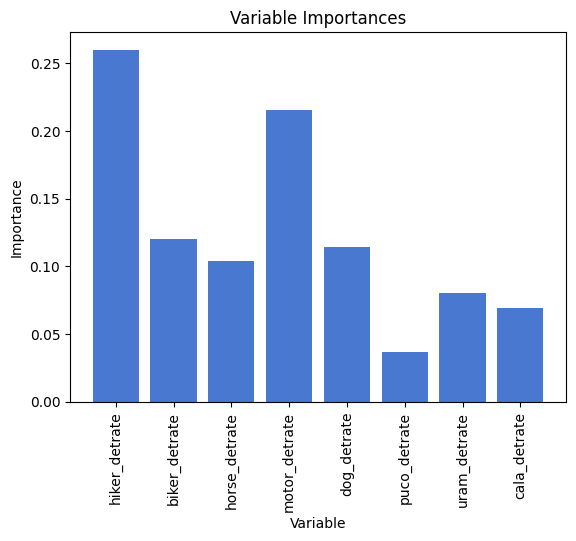

In [11]:
# plotting variable importance 

# set style
plt.style.use('seaborn-muted')

# list of x locations for plotting
x_values = list(range(len(importances)))

# make bar chart
plt.bar(x_values, importances, orientation = 'vertical')

# label tick marks on axes
plt.xticks(x_values, predictors_list, rotation='vertical')

# label axes and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances')

              precision    recall  f1-score   support

         0.0       0.85      0.97      0.90       102
         1.0       0.79      0.38      0.51        29

    accuracy                           0.84       131
   macro avg       0.82      0.67      0.71       131
weighted avg       0.83      0.84      0.82       131



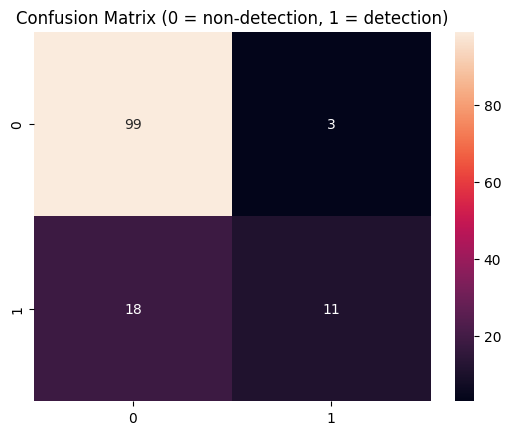

In [12]:
# test model accuracy

# create predictions from testing data
mod_predictions = rf.predict(test_predictors)

# generate confusion matrix and plot
cm = confusion_matrix(test_responses, mod_predictions)
sns.heatmap(cm, annot=True, fmt='d').set_title('Confusion Matrix (0 = non-detection, 1 = detection)')
print(classification_report(test_responses, mod_predictions))

Text(0, 0.5, 'Elk Detection Probability')

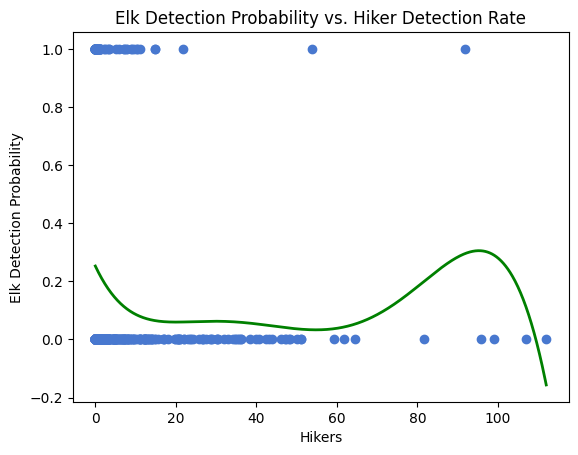

In [16]:
# plot the relationship between hikers and elk detection probability

# sort values for spline to be constructed
stat_weeks_df_sorted = stat_weeks_df.sort_values(by="hiker_detrate") 

# create spline
x,y = stat_weeks_df_sorted['hiker_detrate'],stat_weeks_df_sorted['ceca_p']
spl = UnivariateSpline(x,y, k=5) # k can be adjusted to decrease/increase wiggliness

# set params for plot (x range, number of points)
xs = np.linspace(min(stat_weeks_df['hiker_detrate']), max(stat_weeks_df['hiker_detrate']), 1000)

# plot
plt.scatter(stat_weeks_df_sorted['hiker_detrate'],stat_weeks_df_sorted['ceca_p'])
plt.plot(xs, spl(xs), 'g', lw=2)
plt.title('Elk Detection Probability vs. Hiker Detection Rate')
plt.xlabel('Hikers')
plt.ylabel('Elk Detection Probability')